# Fetch Data

We need to fetch the data from the warehouse we had earlier created and use it for analysis. This is usually the first step in any datascience workflow.



In [6]:
!pip install pandasql

  Using cached pandasql-0.7.3.tar.gz (26 kB)
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=a15f731ba1e3ce76074e301598ed58afe06c966e740011be530b16c185d2f717
  Stored in directory: c:\users\blais\appdata\local\pip\cache\wheels\a6\64\11\62d5f7b88421a5d80068ac9937fe2915e497da3eba900c8f59
Successfully built pandasql


In [1]:
#import necessary libraries

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pymysql
    import pandasql as ps
    import contextlib
    print("Successfully installed libraries ...")
    
except ImportError as IE:
    print("Please install the missing libraries first before proceeding {}".format(IE))
    exit(1)

In [2]:
#define a couple of default styles we wish to rock with
plt.style.use('ggplot')
sns.set_palette('Reds_r')
sns.set_context('notebook')


In [3]:
#define pymysql query for easier querying of our dataframes

def mysql(query,connection: pymysql.connections.Connection):
    return pd.read_sql_query(query,connection)

def sql(query):
    return ps.sqldf(query)

## Database Connection

In [4]:
#creating a connection object 
#create a context manager to handle our sql connection
@contextlib.contextmanager
def sql_connection():
    '''
    Context manager to handle sql connection
    Args: 
        db: database name
    Yield:
        conn: sql connection
    '''
    try:
        conn = pymysql.connect(host='localhost',
                               user='root',
                               password='root',
                               port=3306,
                               db='dwh_whiskey',
                               
                               charset='utf8mb4'
                               )
        print("Successfully connected to database")
        # cursor = conn.cursor()
        yield conn
    except pymysql.MySQLError as e:
        print("Error connecting to database: {}".format(e))
        exit(1)
    finally:
        conn.close()
        print("Connection closed")
        

## Extract Data from the Database

In [8]:
#we use the context manager to get the connection object

with sql_connection() as conn:
    try:
        cursor=conn.cursor()
        query= '''
    
    SELECT 
        f.date,
        d.Day_name as Day,
        d.Month_name as Month,
        d.Year_name as Year,
        f.Product_name as Product,
        f.Alcohol_Price,
        f.Alcohol_Percentage,
        f.Alcohol_Unit,
        c.full_name as customer_name,
        co.country as customer_country,
        f.credit_provider,
        e.full_name as employee_name
        
    FROM dwh_fact as f
    left join whiskey_retail_shop.customers c
    on f.customer_id = c.customer_id
    left join whiskey_retail_shop.countries as co
    on co.country_id = c.country_id 
    left join dwh_employees as e
    on e.employee_id = f.employee_id
    left join dwh_date d
    on d.Date_key = f.Date_key
    order by f.date   
    
    '''
    
    # Generating a Dataframe according to the query
        print("Running query")
        df = mysql(query,conn)
        
    except Exception as e:
        print("Error while connecting to database: {}".format(e))
        exit(1)
    
    #we'll be using read_sql_query from python to query our dataframe
    

Successfully connected to database
Running query
Connection closed


In [9]:
df

,date,Day,Month,Year,Product,Alcohol_Price,Alcohol_Percentage,Alcohol_Unit,customer_name,customer_country,credit_provider,employee_name
0,1991-01-02,Wednesday,Jan,1991,Stauning BastardMezcal Finish,65.25,46.30,93.20,Debra Peron,Aruba,VISA 13 digit,Annie Holmes
1,1991-01-03,Thursday,Jan,1991,Black Gate Batch 1 3 Year OldTBWC Australian S...,99.95,46.00,199.90,George Craft,Niue,Discover,Ann Flores
2,1991-01-03,Thursday,Jan,1991,Cameronbridge 198437 Year Old Signatory,235.00,51.60,335.70,Richard Komorowski,Turkmenistan,VISA 16 digit,Denise Snell
3,1991-01-04,Friday,Jan,1991,Kavalan King Car Conductor,81.95,46.00,117.07,Jason Donohue,French Guiana,VISA 13 digit,Margaret Williams
4,1991-01-04,Friday,Jan,1991,North British Single Grain 201110 Year Old Wat...,44.95,57.10,64.20,Juan Irwin,Cayman Islands,VISA 16 digit,Jeffery Bonson
...,...,...,...,...,...,...,...,...,...,...,...,...
11319,2021-12-27,Monday,Dec,2021,Starward 2016 Sample4 Year Old Exclusive to Th...,7.95,57.00,26.50,Marlene Hall,Uganda,JCB 16 digit,Rose Laperle
11320,2021-12-28,Tuesday,Dec,2021,Hellyers Road Original 'Roaring 40s',53.45,40.00,76.36,Tracy Macauley,Isle of Man,Diners Club / Carte Blanche,Bert Shea
11321,2021-12-29,Wednesday,Dec,2021,Orbital 8 Year OldWorld Blend Sherry Cask Whis...,39.95,46.00,57.07,Amanda Jones,Italy,Mastercard,Grace Ponce
11322,2021-12-31,Friday,Dec,2021,Springbank 1966West Highland Malt Cask #442,15000.00,61.20,20.00,Herman Butler,Antigua and Barbuda,VISA 16 digit,Nedra Beitel


In [26]:
df.to_csv("../data/dwh_fact.csv",index=False)

# Data Analysis

In [10]:
#check and assert datatypes
df.dtypes

date                   object
Day                    object
Month                  object
Year                   object
Product                object
Alcohol_Price         float64
Alcohol_Percentage    float64
Alcohol_Unit          float64
customer_name          object
customer_country       object
credit_provider        object
employee_name          object
dtype: object

## Data Cleaning


In [12]:
#extract all the columns
data_columns=df.columns.to_list()

#Iterate through and change the date column and object columns into category
for column in data_columns:
    
    if column == 'date':
        df[column]=pd.to_datetime(df[column])
        
    if df[column].dtype == 'object':
        df[column]=df[column].astype('category')

In [14]:
df.dtypes

date                  datetime64[ns]
Day                         category
Month                       category
Year                        category
Product                     category
Alcohol_Price                float64
Alcohol_Percentage           float64
Alcohol_Unit                 float64
customer_name               category
customer_country            category
credit_provider             category
employee_name               category
dtype: object

In [15]:
df

,date,Day,Month,Year,Product,Alcohol_Price,Alcohol_Percentage,Alcohol_Unit,customer_name,customer_country,credit_provider,employee_name
0,1991-01-02,Wednesday,Jan,1991,Stauning BastardMezcal Finish,65.25,46.30,93.20,Debra Peron,Aruba,VISA 13 digit,Annie Holmes
1,1991-01-03,Thursday,Jan,1991,Black Gate Batch 1 3 Year OldTBWC Australian S...,99.95,46.00,199.90,George Craft,Niue,Discover,Ann Flores
2,1991-01-03,Thursday,Jan,1991,Cameronbridge 198437 Year Old Signatory,235.00,51.60,335.70,Richard Komorowski,Turkmenistan,VISA 16 digit,Denise Snell
3,1991-01-04,Friday,Jan,1991,Kavalan King Car Conductor,81.95,46.00,117.07,Jason Donohue,French Guiana,VISA 13 digit,Margaret Williams
4,1991-01-04,Friday,Jan,1991,North British Single Grain 201110 Year Old Wat...,44.95,57.10,64.20,Juan Irwin,Cayman Islands,VISA 16 digit,Jeffery Bonson
...,...,...,...,...,...,...,...,...,...,...,...,...
11319,2021-12-27,Monday,Dec,2021,Starward 2016 Sample4 Year Old Exclusive to Th...,7.95,57.00,26.50,Marlene Hall,Uganda,JCB 16 digit,Rose Laperle
11320,2021-12-28,Tuesday,Dec,2021,Hellyers Road Original 'Roaring 40s',53.45,40.00,76.36,Tracy Macauley,Isle of Man,Diners Club / Carte Blanche,Bert Shea
11321,2021-12-29,Wednesday,Dec,2021,Orbital 8 Year OldWorld Blend Sherry Cask Whis...,39.95,46.00,57.07,Amanda Jones,Italy,Mastercard,Grace Ponce
11322,2021-12-31,Friday,Dec,2021,Springbank 1966West Highland Malt Cask #442,15000.00,61.20,20.00,Herman Butler,Antigua and Barbuda,VISA 16 digit,Nedra Beitel


## Descriptive Analysis and Visualization

We want to understand which products produce the most profit

In [18]:
#we create a dataframe containing the top 5 most profitable products
query= '''

SELECT Product,COUNT(*) as Total_Sales,SUM(Alcohol_Price) as Total_Revenue

FROM df
GROUP BY Product
ORDER BY Total_Revenue DESC
LIMIT 100;


'''
top_100_prods=sql(query)

In [19]:
top_100_prods

,Product,Total_Sales,Total_Revenue
0,Karuizawa 36 Year OldSapphire Geisha,17,552500.0
1,Karuizawa 38 Year OldPearl Geisha,13,487500.0
2,Springbank 1965Cadenhead's White Label Cask #2164,17,255000.0
3,Hanyu 1985 The JokerMonochrome Label,3,180000.0
4,Springbank 196531 Year Old Sherrywood Matured ...,11,110000.0
...,...,...,...
95,Macallan 18 Year Old Double Cask2022 Release,16,5120.0
96,Caperdonich 199723 Year Old Daily Dram,14,5110.0
97,Springbank 1965Bot.1993 Sherry Cask Adelphi,1,5000.0
98,SMWS 98.1 (Lomond)1972 Bot.1992,1,5000.0


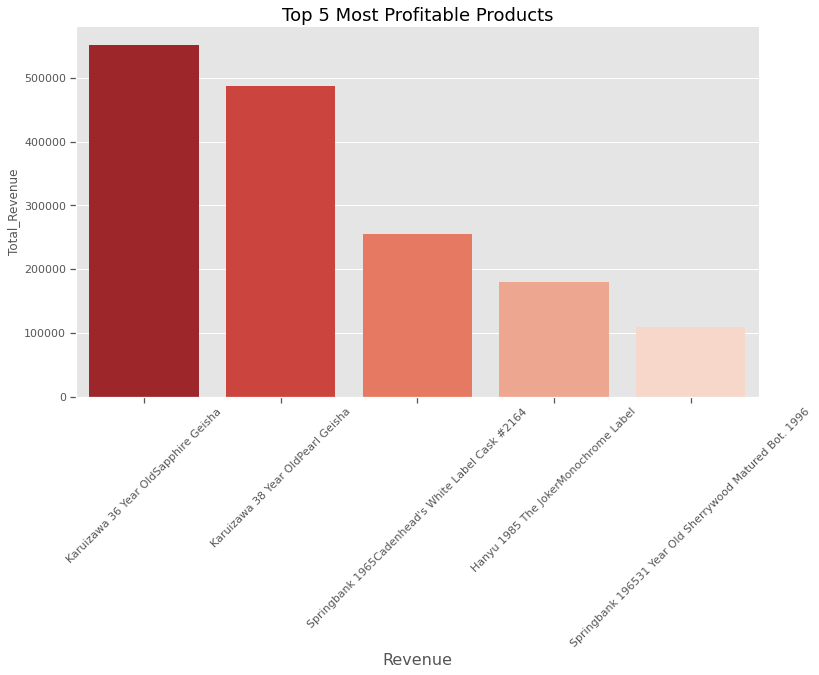

In [26]:
#lets plot the top 5 most profitable products
sns.catplot(data = top_100_prods[:5], x = 'Product', y = 'Total_Revenue',
            kind = 'bar', palette='Reds_r', height = 6, aspect = 2)
plt.xlabel('Product Name',size = 16)
plt.xticks(rotation=45)
plt.xlabel('Revenue',size = 16)

plt.title('Top 5 Most Profitable Products',size = 18)

plt.show()

Which products have generated the most revenue per sales

In [29]:
#we want to see if we can generate a new column to give us the revenue per sale
query= '''

SELECT Product,COUNT(*) as Total_Sales,SUM(Alcohol_Price) as Total_Revenue,SUM(Alcohol_Price)/COUNT(*) as Revenue_Per_Sale
FROM df
GROUP BY Product
ORDER BY Revenue_Per_Sale DESC
LIMIT 100;



'''
top_100_prods_per_rev=sql(query)


In [30]:
top_100_prods_per_rev

,Product,Total_Sales,Total_Revenue,Revenue_Per_Sale
0,Hanyu 1985 The JokerMonochrome Label,3,180000.0,60000.0
1,Springbank 50 Year OldBot.1960s,1,42000.0,42000.0
2,Karuizawa 38 Year OldPearl Geisha,13,487500.0,37500.0
3,Karuizawa 36 Year OldSapphire Geisha,17,552500.0,32500.0
4,Springbank 1966West Highland Malt Sherry Cask ...,2,30000.0,15000.0
...,...,...,...,...
95,Chichibu IPA Cask FinishBot.2017,13,10400.0,800.0
96,Amrut Greedy Angels 10 Year OldPeated Rum Finish,12,9600.0,800.0
97,Highland Park 198932 Year Old Connoisseurs Choice,2,1560.0,780.0
98,St Magdalene 1980Centenary Reserve Gordon & Ma...,2,1500.0,750.0


Which products are most sought after by the customers?

In [32]:
query= '''

SELECT Product,COUNT(*) as Total_Sales
FROM df 
GROUP BY Product
ORDER BY Total_Sales DESC;



'''

top_sales=sql(query)

In [33]:
top_sales

,Product,Total_Sales
0,Cambus 197645 Year Old Xtra Old Particular,72
1,Carsebridge 198235 Year Old Signatory,69
2,Cameronbridge 198437 Year Old Signatory,69
3,Dumbarton 200021 Year Old Watt Whisky,65
4,Cambus 199126 Year Old Sherry Cask Signatory,65
...,...,...
1218,Ben Nevis Coire Leis,1
1219,Balvenie 12 Year OldDouble Wood Small Bottle,1
1220,Auchentoshan 199130 Year Old Blackadder Statem...,1
1221,AnCnoc 2009Bot.2021,1


On which day to customers like to buy the most amount of whiskey

In [37]:
query= '''

SELECT Day,COUNT(*) as Total_Sales

FROM df
GROUP BY Day
ORDER BY Total_Sales DESC


'''

orders_by_day=sql(query)
orders_by_day

,Day,Total_Sales
0,Monday,1671
1,Thursday,1660
2,Sunday,1628
3,Wednesday,1601
4,Saturday,1594
5,Friday,1591
6,Tuesday,1579


what about the month of the year

In [40]:
query= '''

SELECT Month,COUNT(*) as Total_Sales

FROM df
GROUP BY Month
ORDER BY Total_Sales DESC


'''

top_rev_by_month=sql(query)
top_rev_by_month

,Month,Total_Sales
0,Jul,991
1,Aug,985
2,Nov,967
3,Sep,965
4,Jan,954
5,Dec,949
6,Oct,940
7,Mar,933
8,Apr,926
9,May,922


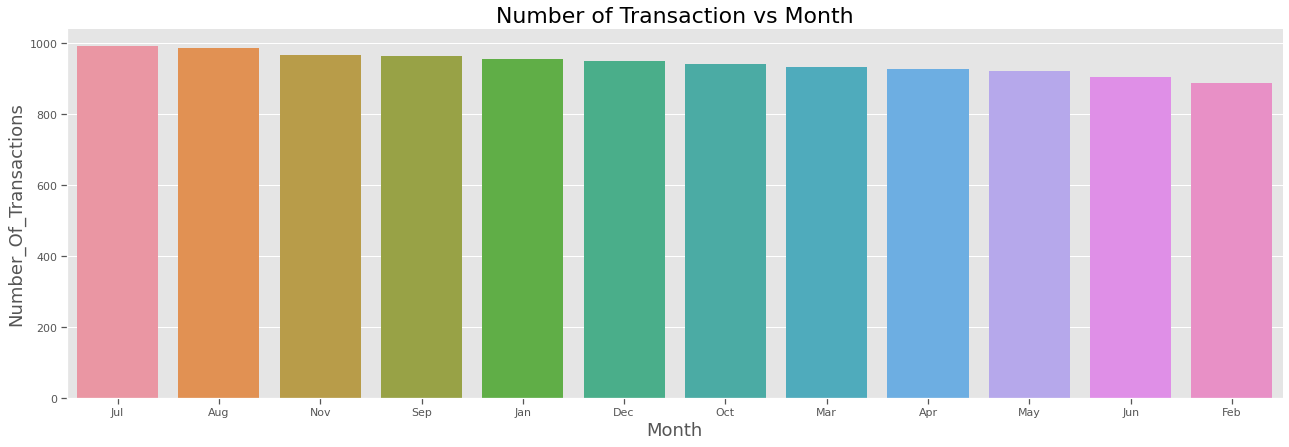

In [41]:
sns.catplot(data = top_rev_by_month, 
            y = 'Total_Sales', x = 'Month', kind = 'bar',
           height = 6, aspect = 3)
plt.xlabel('Month', size = 18)
plt.ylabel('Number_Of_Transactions', size = 18)
plt.title('Number of Transaction vs Month', size = 22)
plt.show()

Is the company having a growing trajectory in terms of sales?


Start of with sales

In [44]:
query= '''

SELECT Year,COUNT(*) as Total_Sales

FROM df
WHERE Year != 2022
GROUP BY Year
ORDER BY Total_Sales DESC


'''

sql(query)

,Year,Total_Sales
0,2005,400
1,2016,394
2,1995,388
3,2002,386
4,1993,382
5,1999,381
6,1997,380
7,2012,377
8,1998,374
9,2006,373


Weird trend there.. nothing much to really do with it

Now with revenue

In [49]:
query= '''

SELECT Year,SUM(Alcohol_Price) as Total_Revenue

FROM df
WHERE Year != 2022
GROUP BY Year



'''

rev_per_year=sql(query)

In [51]:
rev_per_year

,Year,Total_Revenue
0,1991,97085.95
1,1992,146187.65
2,1993,146927.60
3,1994,88185.85
4,1995,168913.80
5,1996,62246.50
6,1997,195077.15
7,1998,138994.30
8,1999,197376.15
9,2000,105998.35


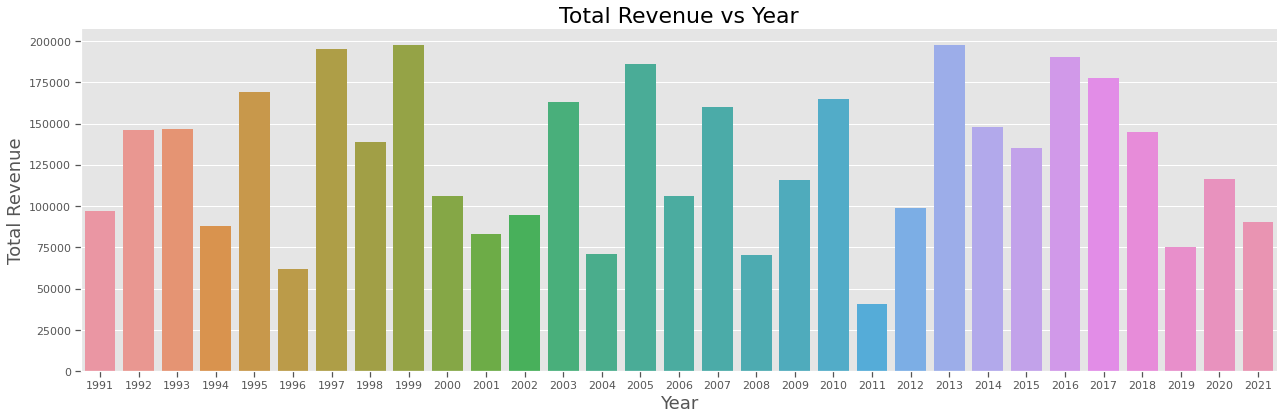

In [58]:
sns.catplot(data = rev_per_year, 
            y = 'Total_Revenue', x = 'Year', kind = 'bar',
           height = 6, aspect = 3)
plt.xlabel('Year', size = 18)
plt.ylabel('Total Revenue', size = 18)
plt.title('Total Revenue vs Year', size = 22)
plt.show()

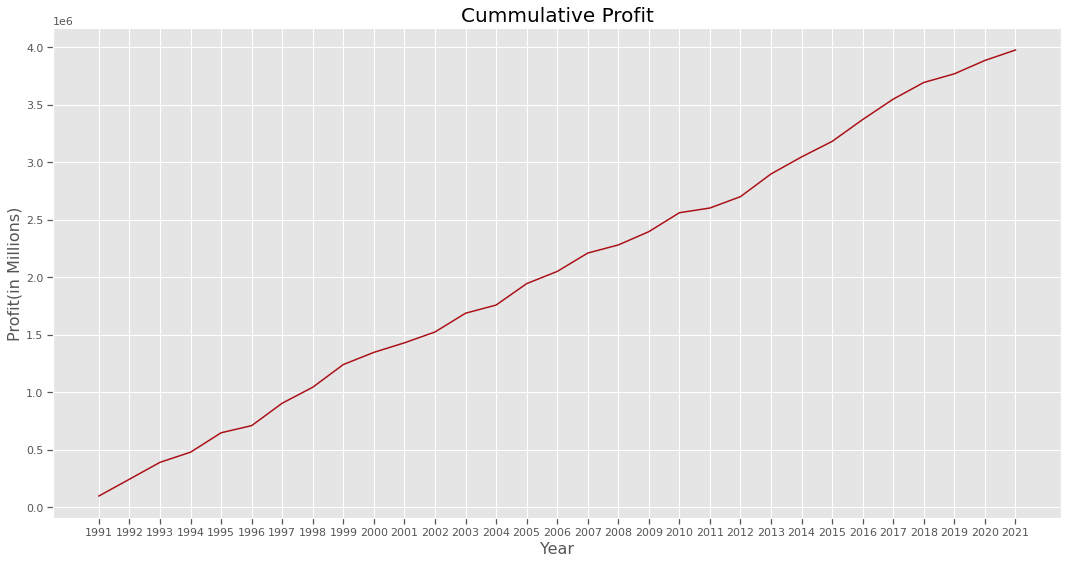

In [50]:
x = rev_per_year.Year
y = np.cumsum(rev_per_year['Total_Revenue'])

plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["figure.autolayout"] = True
plt.plot(x,y)
plt.xlabel('Year', size = 16)
plt.ylabel('Profit(in Millions)', size = 16)
plt.title('Cummulative Profit', size = 20)
plt.show()

where do most customers come from?

In [52]:
query = '''
select 
    count(distinct customer_name) as Number_of_customers, 
    customer_country
    
from df
group by customer_country
order by customer_country asc
'''

customers_by_country = sql(query)

In [53]:
customers_by_country

,Number_of_customers,customer_country
0,4,Afghanistan
1,6,Albania
2,5,Algeria
3,7,American Samoa
4,1,Andorra
...,...,...
236,4,Wallis and Futuna
237,3,Western Sahara
238,6,Yemen
239,5,Zambia


In [55]:
# Filtering the top ten percentile of countries
top_ten_percentile = customers_by_country.sort_values(by = 'Number_of_customers', ascending=False)

top_ten_percentile 

,Number_of_customers,customer_country
33,10,Burkina Faso
77,9,Georgia
122,9,Lithuania
209,9,Syrian Arab Republic
208,9,Switzerland
...,...,...
223,1,Tuvalu
189,1,Saudi Arabia
94,1,Hong Kong
40,1,Central African Republic


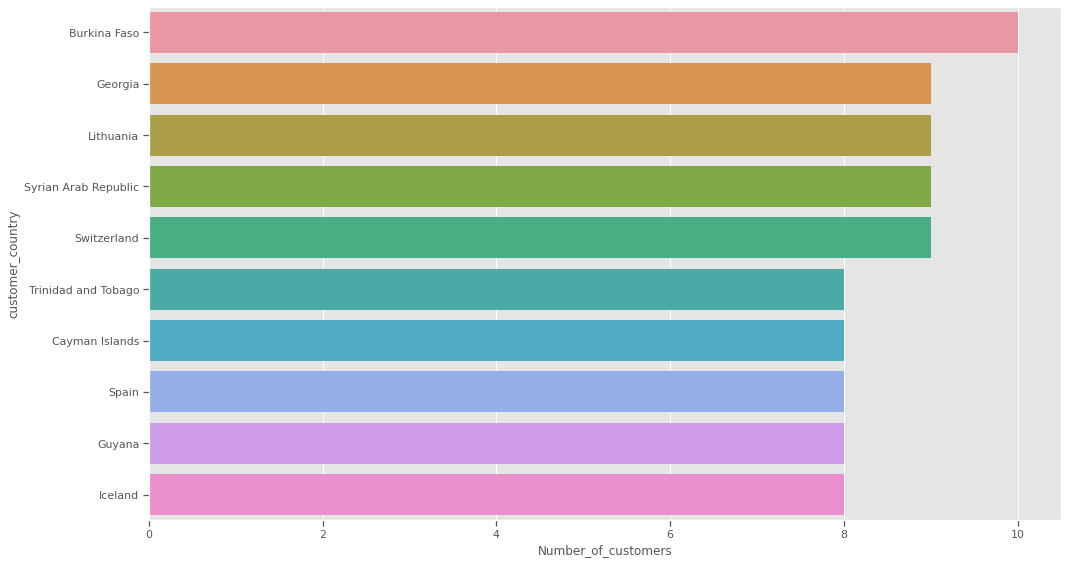

In [57]:
sns.barplot(data =top_ten_percentile[:10], x='Number_of_customers', y='customer_country')
plt.show()